In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path
import os
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
# Importing helper libraries for bayesian optimization
from data_preprocessing_class import dataPreprocessing
from gaussian_process_regression_class import gaussianProcessRegression
from acquisition_functions_class import acqisitionFunctions
from geometry_writer import geometryWriter
from feature_extractor_4 import FeatureExtractor

In [2]:
"""
STEP 0:
Load the input and output data gennerated by SE model for building a GPR model

"""
# Checking if data exists
doesDataFileExist = os.path.isfile("master_feature_output.npy")

# Loading datafiles if they exist
# Else fetching and preparing data from signac workspace
if doesDataFileExist == True:
    # Loading input parameters
    master_parameter_input_n = np.load('master_parameter_input_n.npy', )
    # Loading output EFD coefficients
    master_feature_output = np.load('master_feature_output.npy', )

# Printing shape of the daya
print(np.shape(master_parameter_input_n))
print(np.shape(master_feature_output))

(133, 35)
(133, 80)


In [3]:
"""
STEP 2: Data preprocessing
1. Selects the parameters sampled in LHS from total 35 parameters of the SE model
2. PCA on the out shape features.
"""

data_efd_mean = np.mean(master_feature_output,axis = 0)
data_efd_variance = np.var(master_feature_output,axis = 0)
# Loading in the data processing class
dataPreprocess  = dataPreprocessing(master_parameter_input_n, master_feature_output, 133)
# Converting the input parameters to logscale
master_parameter_input_log = dataPreprocess.inputLogTransform()
print(np.shape(master_parameter_input_log))
# Selecting the parameters that were sampled in the latin hypercube sampling
num_parameters_LHS = 7
LHS_parameter_index = [1, 4, 7, 17, 18, 19, 33]
# Calling in the function to separate out the desired parameters
data_x = dataPreprocess.inputParameterSelection(num_parameters_LHS, LHS_parameter_index, master_parameter_input_log)
print(np.shape(data_x))

# PCA to reduce dimensionality of the output data
total_variance_explained, principalComponents, weights = dataPreprocess.pcaEfdFeatures(8)
print(total_variance_explained)
print(np.shape(weights))


C:\Users\Nilay\Documents\GitHub\Tissue-Cartography\parameter_screening\bayesian_optimization\data_preprocessing_class.py:42: RuntimeWarning: divide by zero encountered in log
  master_parameter_input = np.log(self.master_parameter_input_n)


(133, 35)
(133, 7)
0.8351040196736451
(8, 80)


(7,)
(7,)
[-1.81937813 -1.93823379 -1.87646633 -1.78401882 -1.8260345  -1.91939962
 -1.8461721 ]
[1.42079434 1.41813797 1.44579386 1.40938397 1.4086535  1.40883561
 1.3508899 ]
Iter 1/100 - Loss: 6.599   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 6.170   lengthscale: 0.744   noise: 0.744
Iter 3/100 - Loss: 5.798   lengthscale: 0.798   noise: 0.798
Iter 4/100 - Loss: 5.477   lengthscale: 0.853   noise: 0.853
Iter 5/100 - Loss: 5.200   lengthscale: 0.909   noise: 0.911
Iter 6/100 - Loss: 4.960   lengthscale: 0.965   noise: 0.969
Iter 7/100 - Loss: 4.752   lengthscale: 1.022   noise: 1.029
Iter 8/100 - Loss: 4.571   lengthscale: 1.077   noise: 1.090
Iter 9/100 - Loss: 4.413   lengthscale: 1.131   noise: 1.151
Iter 10/100 - Loss: 4.274   lengthscale: 1.183   noise: 1.213
Iter 11/100 - Loss: 4.151   lengthscale: 1.232   noise: 1.275
Iter 12/100 - Loss: 4.042   lengthscale: 1.279   noise: 1.337
Iter 13/100 - Loss: 3.946   lengthscale: 1.322   noise: 1.399
Iter 14/100 - Loss: 3.859 

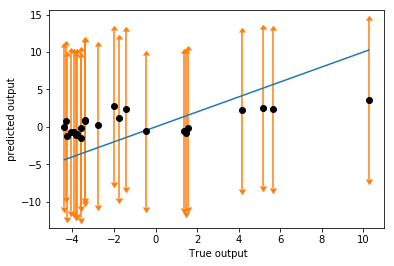

In [4]:
"""
Step 3: Training the GPR model
Input: Parametsr sampled in LHS for the SE model
Output: PC1

"""

data_x_mean = np.mean(data_x, axis=0)
data_x_variance = np.std(data_x, axis=0)
print (np.shape(data_x_mean))
print (np.shape(data_x_variance))

# Normalizing data
data_x = StandardScaler().fit_transform(data_x)
print (np.min(data_x, axis = 0))
print (np.max(data_x, axis = 0))


data_y = principalComponents[:,0]


# To do: Incorporate it in the GPR class
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Defining a RBF kernel
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #defing a Matern kernel
        # mu is the smoothness parameter
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Calling in the gpr class
gpr  = gaussianProcessRegression(data_x, data_y)
# Splitting up the training and test data
train_x, train_y, test_x, test_y = gpr.split_data(110, 133)
# Getting the trained model and likelihood using the training data
model, likelihood = gpr.GP_Regressor(train_x, train_y, test_x, test_y, 100, 1, ExactGPModel)


In [5]:
""" STEP 4: Acquistion function:  Expected improvenet
"""
"""
from smt.sampling_methods import LHS

xlimits = np.array([[-2, 2],[-2, 2],[-2, 2],[-2, 2],[-2, 2],[-2, 2],[-2, 2]])
sampling = LHS(xlimits = xlimits)
# Defining numvber of samples
num_samples = 10000000
# Implementing latin hypercube sampling
x = sampling(num_samples)
"""

""" Temporary bypassing due to anaconda smt installation errors"""
# Defining numvber of samples
num_samples = 1000000
# Implementing latin hypercube sampling
x = np.random.rand(num_samples, 7)


# Calling in the acquisition function class
af = acqisitionFunctions(x, test_x, test_y)
# Calculating the xpected improvement
ei = af.expected_improvement(model, likelihood, 0.9)

# Finding the indez that leads to maximum acquisition function
x_sampled_index = np.argmax(ei)
# Assessing the new sampled value
x_sampled_logscale_standardized = x[x_sampled_index,:]
# Converting x sampled into parameter space
# Multiplying by standard deviation and adding the mean pf data
x_sampled = 10**(np.add(np.multiply(x_sampled_logscale_standardized,data_x_variance), data_x_mean)) 

print(x_sampled)
print(np.shape(x_sampled))



[1.43405192e-12 2.05105481e-09 5.07280340e-11 2.76277086e+00
 2.50550894e-04 1.07948276e-03 4.59867405e-11]
(7,)


In [ ]:
"""
STEP 4: Running surface evolver simulations and estimating new ysampled

"""

""" Step a: Creating parameter value """
# Initializaib=ng the surface evolver parameters
paraminputs = [0,0.0001,0,0,0,0,0,0.001,0,0,0, 0.1,0.1,10,0.1,0.1,0.1,0.1,10,0.0001,0.001,0.001, 1,1,0.6,0.6,0.6,0.6,0.2,0.1,3,0.6,1.8, 0.001,0.001]
# Repalcaing the parameters with newly sampled values

paraminputs[1] = x_sampled[0,]
# tension cuboidal basal
paraminputs[4] = x_sampled[1,]
# tension columnar basal
paraminputs[7] = x_sampled[2,]
# k columnar apical
paraminputs[17] = x_sampled[3,]
# k columnar basal
paraminputs[18] = x_sampled[4,]
# k columnar lateral
paraminputs[19] = x_sampled[5,]
# K_ECM
paraminputs[33] = x_sampled[6,]

# Defining the set system pressure
param_pressure = 0.001

""" Step b: Writing geometry file"""
geometryWriter(paraminputs, param_pressure, 'wingDisc')

""" Step c: Running surface evolver simulations"""
os.system("/home/nkumar4/Desktop/evolver_installation/src/evolver wingDisc.fe")
os.system("exit")

""" Step d: Extracting EFD features """
fe = FeatureExtractor('vertices.txt', 'log_edges.xlsx')
efd_coeff_sampled = fe.tissue_efd_coeff(20)
efd_coeff_sampled_reshaped = np.reshape(efd_coeff_sampled, (80,))

""" Step e: Converting efd features to PCs/ ysampled"""
# normalizing efd coefficients with existing data mean and variance
efd_coeff_sampled_normalized = (np.add(np.multiply(efd_coeff_sampled_reshaped,data_efd_variance), data_efd_mean)) 
efd_coeff_sampled_normalized = np.reshape(efd_coeff_sampled_normalized, (80,1))
# Multiplying EFD coefficients by already obtained weight of pc
efd_coeff_sampled_normalized_pc = np.matmul(weights,efd_coeff_sampled_normalized)
# Reshaping array for appending to the original data array
y_sampled = np.reshape(efd_coeff_sampled_normalized_pc, (1,8))
print(np.shape(efd_coeff_sampled_normalized_pc))

In [ ]:
"""STEP 5: UPDATING TRAINING DATA"""
#data_y = np.vstack((data_y, y_sampled[0,0]))
data_x = np.vstack((data_x, np.reshape(x_sampled,(1,7))))
print(np.shape(data_x))